# PNEUMONIA DETECTION CHALLENGE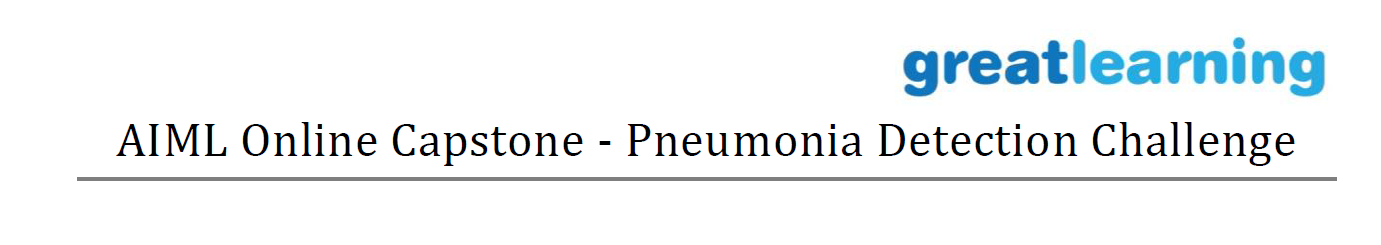

## The Real Problem
Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli.
Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2017, 920,000 children under the age of 5 died from the disease. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.
CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.
## Pneumonia Detection
Now to detection Pneumonia we need to detect Inflammation of the lungs. In this project, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

## Business Domain 
Value Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

## Project Description
In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image.
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.
In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

## Install Necessary Dependencies

In [1]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 18.6 MB/s 


In [2]:
import numpy as np
import cv2
import pydicom as dicom
from skimage import exposure
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as patches
from  PIL import Image, ImageDraw
from skimage import io
from matplotlib import pyplot as plt
import pandas as pd


#Mount Google drive for dataset preparation, model training and Inference

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/capstone project')

## Exploratory Data Analysis on the Dataset

In [27]:
train_labels= pd.read_csv("/content/drive/MyDrive/capstone project/stage_2_train_labels.csv")
class_labels = pd.read_csv("/content/drive/MyDrive/capstone project/stage_2_detailed_class_info.csv")

In [29]:
images_path = "/content/drive/MyDrive/capstone project/stage_2_train_images"

In [30]:
print(train_labels.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [32]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [33]:
print('The train_label dataframe has {} rows and {} columns.'.format(train_labels.shape[0], train_labels.shape[1]))

The train_label dataframe has 30227 rows and 6 columns.


In [34]:
# Number of duplicates in patientId:
print('Number of unique patientId are: {}'.format(train_labels['patientId'].nunique()))

Number of unique patientId are: 26684


## Visualising the details of the DCM file

In [37]:
import pydicom

patientId = train_labels['patientId'][0]
dcm_file = f'/content/drive/MyDrive/capstone project/stage_2_train_images/{patientId}.dcm'
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [38]:
img = dcm_data.pixel_array
print(type(img))
print(img.dtype)
print(img.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


In [39]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [40]:
class_labels.shape

(30227, 2)

In [41]:
class_labels.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [42]:
print('Size of Dataset 1: ',train_labels.shape)
print('Size of Dataset 2: ',class_labels.shape)
print('Number of Unique X-Rays in Dataset 1 : ',train_labels['patientId'].nunique())
print('Number of Unique X-Rays in Dataset 2 : ',class_labels['patientId'].nunique())

Size of Dataset 1:  (30227, 6)
Size of Dataset 2:  (30227, 2)
Number of Unique X-Rays in Dataset 1 :  26684
Number of Unique X-Rays in Dataset 2 :  26684


## Merged dataframe showing the class labels and the patient details with bounding box details

In [43]:
merged = pd.merge(left = train_labels, right = class_labels, how = 'left', on = 'patientId') # Merge
merged = merged.drop_duplicates() # Remove duplicates

merged.head(10)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
6,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
8,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
10,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity
12,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity


In [44]:
pd.pivot_table(merged,index=["Target"], values=['patientId'], aggfunc='count')

,patientId
Target,
0,20672
1,9555


In [45]:
pd.pivot_table(merged,index=["class"], values=['patientId'], aggfunc='count')

,patientId
class,
Lung Opacity,9555
No Lung Opacity / Not Normal,11821
Normal,8851


## Distribution of Patient IDs based on classes labels defined.
### We have 3 classes in total with 'No Lung Opacity/Not Normal' classified as non-pneumonia cases. We need to understand whether some cases are actually mis classified here

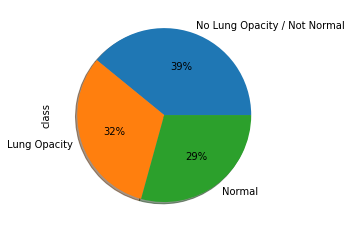

In [46]:
merged["class"].value_counts().plot(kind='pie',autopct='%1.0f%%', shadow=True, subplots=False)

In [47]:
pd.pivot_table(merged,index=["Target"], aggfunc='count')

,class,height,patientId,width,x,y
Target,,,,,,
0,20672,0,20672,0,0,0
1,9555,9555,9555,9555,9555,9555


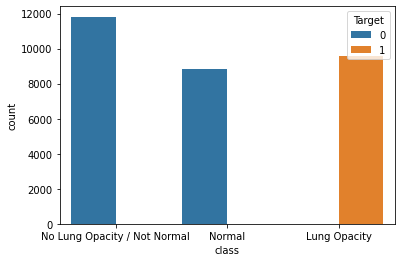

In [50]:
import seaborn as sns
sns.countplot(x = 'class', hue = 'Target', data = merged)

## Creating a correlation plot to understand  

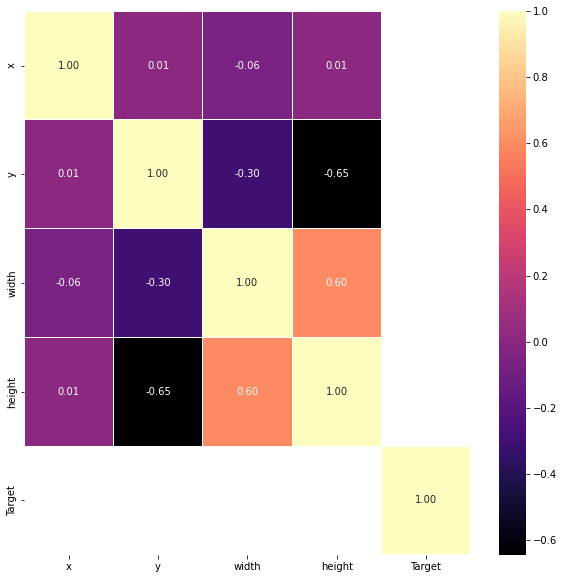

In [51]:
fig,ax = plt.subplots(figsize=(10, 10))   
sns.heatmap(merged.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma") 
plt.show()

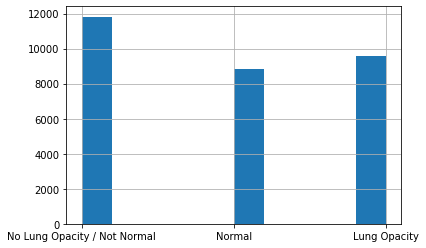

In [52]:
# Look at the amounts in each of the different classes
merged['class'].hist();

In [54]:
import os

train_labels_pos = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height'])

k = 0
for i in range(len(train_labels)):
    if train_labels.loc[i]['Target'] == 1:
        train_labels_pos.loc[k] = train_labels.loc[i]
        k += 1

print('Positive instances dataframe shape:', train_labels_pos.shape)
train_paths = [os.path.join(images_path, image[0]) for image in train_labels_pos.values]

Positive instances dataframe shape: (9555, 5)


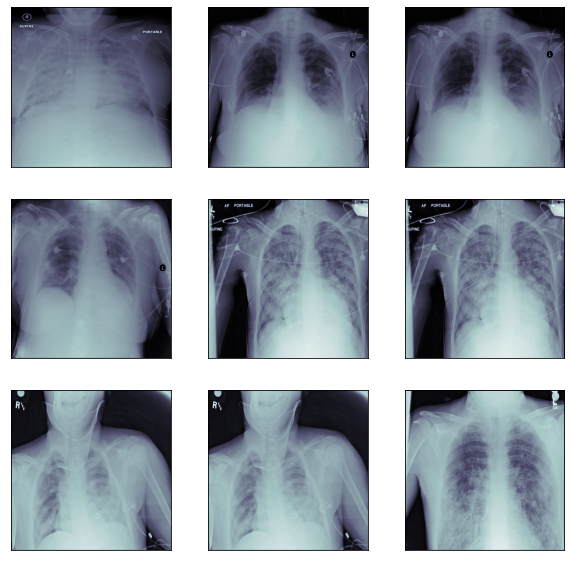

In [55]:
from pydicom import dcmread

def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap='bone')

imshow()


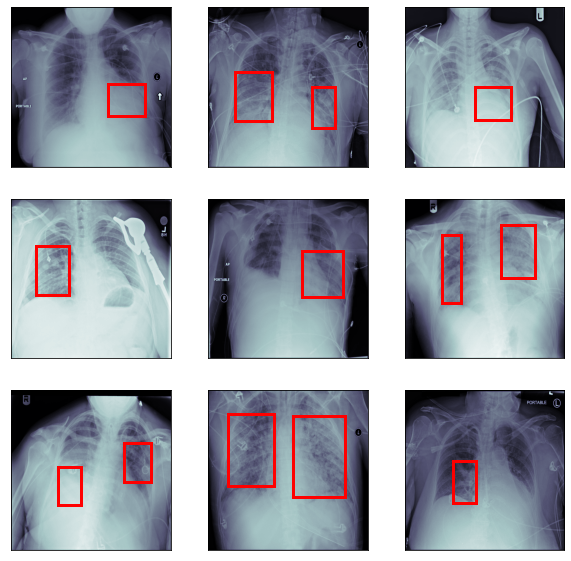

In [56]:
def show_image_with_bboxes(num_to_show=9):
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        id_= np.random.choice(train_labels_pos['patientId'].values)

        current_axis = plt.gca()
        img=pydicom.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
        plt.imshow(img,cmap='bone')


        current_axis = plt.gca()
        boxes=train_labels_pos[['x','y','width','height']][train_labels_pos['patientId']==id_].values

        for box in boxes:
            x=box[0]
            y=box[1]
            w=box[2]
            h=box[3]
            current_axis.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3)) 
        
show_image_with_bboxes()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 432x288 with 0 Axes>

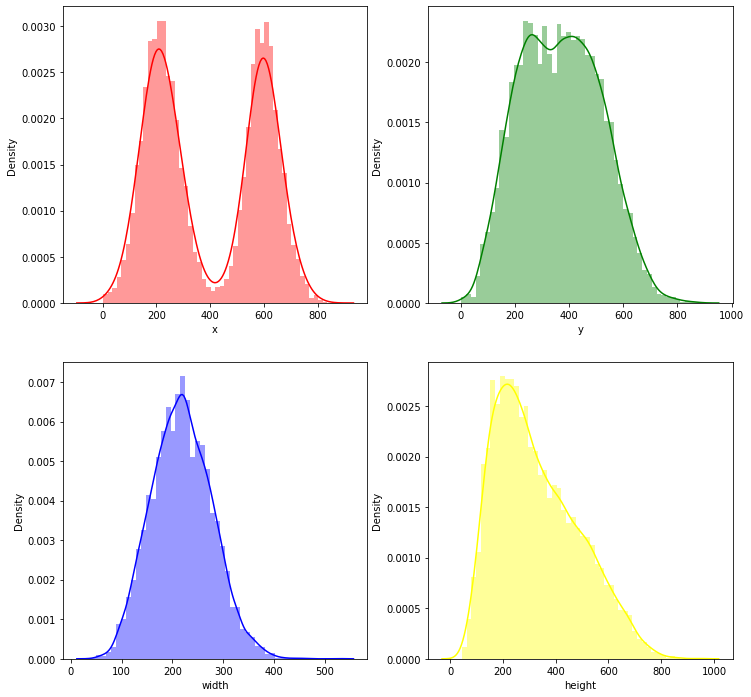

In [57]:
target1 = train_labels[train_labels['Target']==1]
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="green", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="blue", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="yellow", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both')
plt.show()

In [58]:
def fetch_image_details(i,data_row,f, ax):
        patientImage = data_row['patientId']+'.dcm'
        
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))

def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        fetch_image_details(i,data_row,f, ax)
    plt.show()

In [59]:
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        fetch_image_details(i,data_row,f, ax)
        rows = train_labels[train_labels['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(patches.Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'],  linewidth=2, edgecolor='r', facecolor='none'))
    plt.show()

NameError: ignored

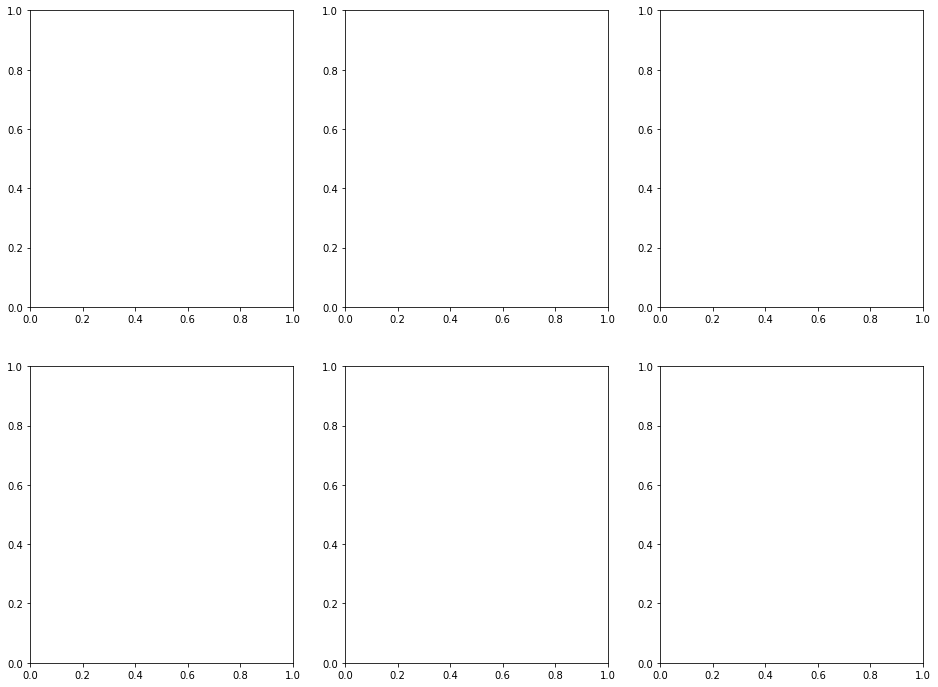

In [60]:
show_dicom_images_with_boxes(train_labels[train_labels['Target']==1].sample(6))

# Model Selection and Training

## We are Using the Tensorflow Object detection API for our task. We have cloned the API from the git and installed the necessary dependencies using pip resolver
## We will proceed with converting the images into TF records as documented in this API

In [5]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 71614, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 71614 (delta 5), reused 26 (delta 5), pack-reused 71588
Receiving objects: 100% (71614/71614), 578.80 MiB | 8.81 MiB/s, done.
Resolving deltas: 100% (50614/50614), done.
Checking out files: 100% (3016/3016), done.


In [6]:
os.chdir('/content/drive/MyDrive/capstone project/models/research')

In [8]:
!protoc object_detection/protos/*.proto --python_out=.

In [14]:
!cp object_detection/packages/tf2/setup.py .

## Import dataset and convert into jpeg format

In [18]:
import glob2
import os
import pickle
training_data_dir_jpg = '/content/drive/MyDrive/capstone project/stage_2_train_images_jpg'
f_names_jpg = glob2.glob(training_data_dir_jpg+'/*.jpg')

In [19]:
f_names_jpg[0]

'/content/drive/MyDrive/capstone project/stage_2_train_images_jpg/818c3ac1-b27c-4d9e-8849-f97127647c97.jpg'

In [20]:
label_info_df = pd.read_csv('/content/drive/MyDrive/capstone project/stage_2_train_labels.csv')

In [21]:
label_info_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


## Function to convert to VOC format for inputing to data preparation stage of TF model

In [61]:
def to_VOC_format(center_x, center_y,width, height):
    """
    Convert center coordinate format to min max coordinateformat
    """
    x_min = center_x - 0.5 * width
    y_min = center_y - 0.5 * height
    x_max = center_x + 0.5 * width
    y_max = center_y + 0.5 * height
    return x_min, y_min, x_max, y_max

## Group bounding boxes based on patientIDs into single list

In [65]:
info_dict = {}
unique_ids = label_info_df['patientId']
for i,info in enumerate(unique_ids):
    bbox_list = []
    bbox_list.append(label_info_df['x'][i])
    bbox_list.append(label_info_df['y'][i])
    bbox_list.append(label_info_df['width'][i])
    bbox_list.append(label_info_df['height'][i])
    if info not in info_dict:
      info_dict[info] = [bbox_list]
    else:
      info_dict[info].append(bbox_list)

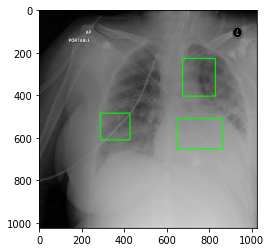

In [66]:
# creating ground truth box and labels for each ground truth

bbox_list = np.array(info_dict['2f686840-18b3-45ac-a2bb-6140e3b0ac73']) # xmin, ymax, xmax, ymin

# labels 1 for zebra, 0 for background
labels = np.array([1, 1])

# visualize ground truth box
img_ = cv2.imread(training_data_dir_jpg+'/'+'2f686840-18b3-45ac-a2bb-6140e3b0ac73'+'.jpg')
for i, bbox in enumerate(bbox_list):
  bbox = [int(c) for c in bbox]
  bbox1,bbox2,bbox3,bbox4 = to_VOC_format(bbox[0], bbox[1],bbox[2], bbox[3])
  cv2.rectangle(img_, (int(bbox1), int(bbox2)), (int(bbox3), int(bbox4)), color=(0, 255, 0), thickness=3) 
plt.imshow(img_)
plt.show()   

## Define the function to prepare dataset feature map

In [25]:
import tensorflow.compat.v1 as tf

from object_detection.utils import dataset_util

####Delete all flags before declare#####

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
FLAGS = flags.FLAGS


def create_tf_example(example):
  # TODO(user): Populate the following variables from your example.
  height = 512 # Image height
  width = 512 # Image width
  filename = None # Filename of the image. Empty if image is not from file
  encoded_image_data = None # Encoded image bytes
  image_format = jpeg # b'jpeg' or b'png'

  xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
  xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
  ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
  ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
  classes_text = [] # List of string class name of bounding box (1 per box)
  classes = [] # List of integer class id of bounding box (1 per box)

  tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))
  return tf_example

In [ ]:
for i in label_

In [ ]:
def main(_):
  writer = tf.python_io.TFRecordWriter(FLAGS.output_path)

  # TODO(user): Write code to read in your dataset to examples variable

  for example in examples:
    tf_example = create_tf_example(example)
    writer.write(tf_example.SerializeToString())

  writer.close()

if __name__ == '__main__':
  tf.app.run()